In [2]:
from sklearn import preprocessing
import numpy as np
import pandas as pd

df = pd.read_csv("nuclear/data.csv")

In [3]:
df_2d= df.drop(columns = ['AP', 'RH', "PE"])
# df_2d = df.drop(columns = ['z'])


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_2d = scaler.fit_transform(df_2d)
# df_2d = preprocessing.scale(df_2d)

In [5]:
import matplotlib.pyplot as plt

# df_2d = df_2d[:10000,]

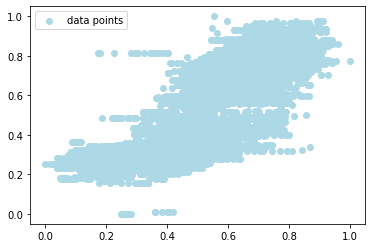

In [6]:

# df_2d=  df_2d[:10000,]
fig,ax = plt.subplots(1)


x = df_2d[:,0]
y = df_2d[:,1]

ax.scatter(x, y, color='lightblue', label='data points')
ax.legend(loc='upper left')


In [7]:
num_elements = 5000
minX = min(x)
maxX = max(x)
Q1 = np.random.uniform(minX, maxX, num_elements)

minY = min(y)
maxY = max(y)
Q2 = np.random.uniform(minY, maxY, num_elements)
# fig2 = plt.figure()
# ax2 = fig2.add_subplot()
# plt.plot(Q1, Q2, 'o', c="red")
# plt.show()

In [8]:
# L is half the length of the rectangle
maxSize  =max(maxX, maxY)/3
L = np.random.uniform(low = 0, high= maxSize/2, size = num_elements)


In [9]:
query_lst = []
for Q1_, Q2_, L_ in zip(Q1, Q2, L):
    query = [Q1_, Q2_, L_, L_]
    query_lst.append(query)

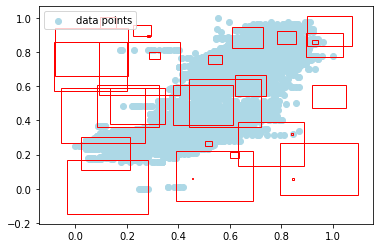

In [10]:
import matplotlib.patches as patches

fig,ax = plt.subplots(1)
# x = df_2d[:,0]
# y = df_2d[:,1]

ax.scatter(x, y, color='lightblue', label='data points')
ax.legend(loc='upper left')


for query in query_lst [:30]:
    # Leftmost point of square
    a,b = query[0] - query[2], query[1] - query[3]
    # Assumes Square
    length = query[3] * 2

    rect = patches.Rectangle((a,b),length, length, edgecolor='r', fill=False, zorder=2, label = "query range")
    # currentAxis = plt.gca()
    ax.add_patch(rect)


plt.show()


In [11]:
def inRange (Q, X1, X2):
    Q1 = Q[0]
    Q2 = Q[1]
    L1 = Q[2]
    L2 = Q[3]

    if (Q1 - L1 <= X1 and X1 <= Q1 +L1) and (Q2 - L2 <= X2 and X2 <= Q2 +L2):
        return True
    return False

In [12]:
from scipy.stats import pearsonr
import math
import statistics
from sklearn.linear_model import LinearRegression
def getResults(query_lst, X1, X2):
    results = []
    for _Q in query_lst:
        count = 0
        valid_X1_lst =[]
        valid_X2_lst =[]
        df = []
        for _X1, _X2 in zip(X1, X2):
            if inRange(_Q, _X1, _X2):
                count+=1
                valid_X1_lst.append(_X1)
                valid_X2_lst.append(_X2)
                df.append([_X1, _X2])
        
        if count >=2:
            Q_dict = {
                'query': _Q, 
                'count': count,
                "x1_avr": np.mean(valid_X1_lst), 
                "x2_avr": np.mean(valid_X2_lst), 
                'pearson': pearsonr(valid_X1_lst, valid_X2_lst)[0],
                'X1_reg_coef':  statistics.mean(LinearRegression().fit(df,valid_X1_lst).coef_),
                'X2_reg_coef':  statistics.mean(LinearRegression().fit(df,valid_X2_lst).coef_)
            }
            add =True
            for v in Q_dict.values():
                if isinstance(v, list)!=True: 
                
                    if math.isnan(v):
                        add =False
                
            if add: 
                results.append(Q_dict)

    return results

    

In [13]:
from sklearn.model_selection import train_test_split


def get_training_data(y_parameter):
    data = getResults(query_lst, x ,y)
    queries = [query_dict["query"] for query_dict in data]
    results = [query_dict[y_parameter] for query_dict in data]
    return queries, results, data

In [14]:
from sklearn.model_selection import train_test_split


def get_training_data_split(y_parameter):
    data = getResults(query_lst, x ,y)
    queries = [query_dict["query"] for query_dict in data]
    results = [query_dict[y_parameter] for query_dict in data]
    train_data, validation_data, train_labels, validation_labels = train_test_split(queries, results, test_size=0.3)

    print('Training set contains {:d} rows.'.format(len(train_data)))
    print('Vadlidation set contains {:d} rows.'.format(len(validation_data)))

    return train_data, train_labels, validation_data, validation_labels

In [15]:
train_data, train_labels, rawData = get_training_data("count")

In [16]:
td,tl,vd,vl  = get_training_data_split("count")

Training set contains 2121 rows.
Vadlidation set contains 909 rows.


In [17]:
from sklearn.metrics import make_scorer
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
smape_scorer=  make_scorer(smape, greater_is_better=False)

In [18]:

# import sklearn.metrics as metrics
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score
# from numpy import mean

# def globalModelPrediction2(model, name):
#     cv = KFold(n_splits=10, random_state=1, shuffle=True)

#     scores_smape = cross_val_score(model, train_data, train_labels, scoring=smape_scorer, cv=cv, n_jobs=-1)
 
#     print("Symmetric Mean Absolute Percentage Error for " + name + ": " + str(int(mean(np.absolute(scores_smape))))+"%")

#     scores_mae = cross_val_score(model, train_data, train_labels, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
 
#     print("Mean Absolute Error for " + name + ": " + str(int(mean(np.absolute(scores_mae)))))

#     scores_r2 = cross_val_score(model, train_data, train_labels, scoring='r2', cv=cv, n_jobs=-1)
 
#     print("R2 Score for " + name + ": " + str(round(mean(scores_r2), 2)))

In [19]:

import sklearn.metrics as metrics
from numpy import mean

def globalModelPrediction(model, name):
    model.fit(td,tl)
    vp = model.predict(vd)
    print('Symmetric Mean Absolute Percentage Error for %s: %.0f' % (name, smape(vl, vp))+'%')
    print('Mean Absolute Error for %s: %.0f' % (name, metrics.mean_absolute_error(vl, vp)))
    print('R2 Score for %s: %.2f' % (name, metrics.r2_score(vl, vp)))
    
    

In [20]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
globalModelPrediction(lr, "Linear Regression")

Symmetric Mean Absolute Percentage Error for Linear Regression: 106%
Mean Absolute Error for Linear Regression: 490
R2 Score for Linear Regression: 0.25


In [21]:
from sklearn import svm
globalModelPrediction(svm.SVR(), "Support Vector Regression")

Symmetric Mean Absolute Percentage Error for Support Vector Regression: 115%
Mean Absolute Error for Support Vector Regression: 507
R2 Score for Support Vector Regression: -0.18


In [22]:
from sklearn.neighbors import KNeighborsRegressor
globalModelPrediction(KNeighborsRegressor(), "K Nearest Neighbors Regression")


Symmetric Mean Absolute Percentage Error for K Nearest Neighbors Regression: 36%
Mean Absolute Error for K Nearest Neighbors Regression: 79
R2 Score for K Nearest Neighbors Regression: 0.97


In [23]:
from sklearn.gaussian_process import GaussianProcessRegressor
globalModelPrediction(GaussianProcessRegressor(), "Gaussian Process Regression")

Symmetric Mean Absolute Percentage Error for Gaussian Process Regression: 61%
Mean Absolute Error for Gaussian Process Regression: 86
R2 Score for Gaussian Process Regression: 0.97


In [24]:
from sklearn import tree
globalModelPrediction(tree.DecisionTreeRegressor(), "Decision Tree Regression")


Symmetric Mean Absolute Percentage Error for Decision Tree Regression: 47%
Mean Absolute Error for Decision Tree Regression: 130
R2 Score for Decision Tree Regression: 0.91


In [25]:
from sklearn.ensemble import AdaBoostRegressor
globalModelPrediction(AdaBoostRegressor(), "Ada Boost Regression")


Symmetric Mean Absolute Percentage Error for Ada Boost Regression: 97%
Mean Absolute Error for Ada Boost Regression: 457
R2 Score for Ada Boost Regression: 0.34


In [26]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import copy

def build_cluster_data(all_data, train_data, train_labels, model):
    visualizer = KElbowVisualizer(KMeans(), k=(1,12))
    visualizer.fit(np.array(all_data))
    k = visualizer.elbow_value_
    cluster_data = {i: {'data': [], 'labels': []} for i in range(k)}
    kmeans = KMeans(n_clusters=k).fit(all_data)
    for query, label, cluster_id in zip(train_data, train_labels, kmeans.predict(train_data)):
        cluster_data[cluster_id]['data'].append(query)
        cluster_data[cluster_id]['labels'].append(label)
       
    for cluster in cluster_data.values():
        m = copy.deepcopy(model)
        m.fit(cluster['data'], cluster['labels'])
        cluster["model"] = m

    return cluster_data, kmeans, k

In [27]:
import sklearn.metrics as metrics
from numpy import mean

def validate_data(cluster_data, validation_data, validation_labels, kmeans):
    validation_cluster_data = {i: {'data': [], 'labels': []} for i in range(k)}
    predicted_clusters  = kmeans.predict(validation_data)
    for query, label, cluster_id in zip(validation_data, validation_labels, predicted_clusters):
        validation_cluster_data[cluster_id]['data'].append(query)
        validation_cluster_data[cluster_id]['labels'].append(label)

    mae_list = []
    r2_list = []
    smape_list = []
    for cluster_key, cluster in zip (validation_cluster_data.keys(), validation_cluster_data.values()):
        cvd =  validation_cluster_data[cluster_key]['data']
        cvl =  validation_cluster_data[cluster_key]['labels']
        model = cluster_data[cluster_key]['model']
        cvp = model.predict(cvd)
        
        smape_list.append(smape(cvl, cvp))
        mae_list.append(metrics.mean_absolute_error(cvl, cvp))
        r2_list.append(metrics.r2_score(cvl, cvp))

    print("Symmetric Mean Absolute Percentage Error:"  + str(int(mean(smape_list)))+"%")

    print("Mean Absolute Error: " + str(int(mean(mae_list))))

    print("R2 Score: " + str(round(mean(r2_list), 2)))
    return validation_cluster_data

In [28]:
def print_clusters(cluster_data):
    colors = ['red', "blue", 'black', 'green']
    fig,ax = plt.subplots(1)

    for label, cluster, color  in zip(cluster_data.keys(), cluster_data.values(), colors):
        x = [i[0] for i in cluster['data']]
        y = [i[1] for i in cluster['data']]   
        ax.scatter(x, y, color=color, label='Cluster: ' + str(label))
        ax.legend(loc='upper left')
    a = [i[0] for i in kmeans.cluster_centers_]
    b = [i[1] for i in kmeans.cluster_centers_]
    ax.scatter(a, b, color="yellow")

Symmetric Mean Absolute Percentage Error:50%
Mean Absolute Error: 59
R2 Score: 0.99


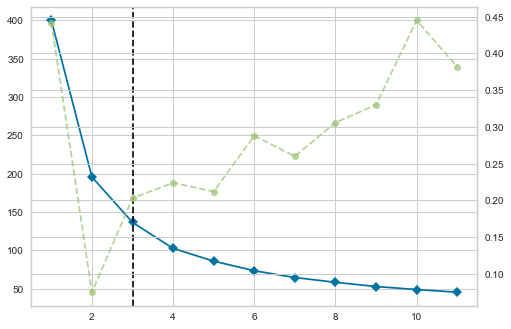

In [50]:
model =  GaussianProcessRegressor()
cluster_data, kmeans, k = build_cluster_data(train_data, td, tl, model)
validation_clusters = validate_data(cluster_data, vd, vl, kmeans)


In [30]:
def update_clusters(model, new_queries):
    new_train_data = train_data + new_queries
    cluster_data, kmeans, k = build_cluster_data(new_train_data, td, tl, model)
    return cluster_data, kmeans, k

In [46]:
def predict_query(queries):
    cluster_data, kmeans, k = update_clusters(model, queries)
    predicted_clusters  = kmeans.predict(queries)
    results = []
    for key, query in zip(predicted_clusters, queries):
        predicted_label = cluster_data[key]['model'].predict([query])[0]
        results.append(int(predicted_label))
    print(results)

[396, 1390, -2, 3290, 51, 950, -10, 1971, 368, 110]
[406, 1187, 3, 2998, 3, 1033, 12, 1987, 415, 122]


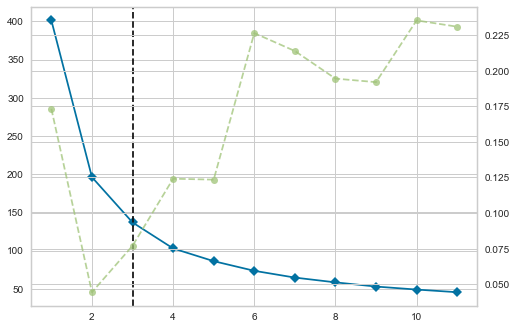

In [47]:
predict_query(vd[:10])
print(vl[:10])